### TP 1 - Optimización - Nieva, Sofía

# Consigna 1 - Random restart 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import norm
from numpy.linalg import solve
from numpy.linalg import eigvals
from time import time
from math import sqrt
from fx_test_2 import langermann

Funciones previas necesarias

In [2]:
def derivada_parcial(f,a,i):
    h = 0.1
    e = np.zeros(a.shape)
    e[i]=1
    z = (f(a+(h*e))-f(a-(h*e)))/(2*h)
    h = h/2
    y = (f(a+(h*e))-f(a-(h*e)))/(2*h)
    error = norm(y-z)
    it = 1
    while it<750 and error>1e-8 and (y != np.nan) and (y != np.inf) and y!= 0:
        error = norm(y-z)
        z = y
        h = h/2
        y = (f(a+(h*e))-f(a-(h*e)))/(2*h)
        it = it + 1
    return z
    
def gradiente(f,a):
    n = a.shape[0]
    grad = np.zeros(a.shape)
    for i in range(0,n):
        grad[i] = derivada_parcial(f,a,i)
    return grad  

def hessiano(f,a): 
    n = a.shape[0]
    H = np.zeros((n,n))
    der_parcial = lambda a: derivada_parcial(f,a,i)     
    for i in range(0,n):
        H[i,:] = gradiente(der_parcial,a)
    return H

Métodos para obtener la longitud de paso

In [3]:
def aurea(f,x,d,eps=1e-5,ro=1):
    tita_1 = (3-sqrt(5))/2
    tita_2 = 1-tita_1
    a, s, b = 0, ro, 2*ro
    phi_b, phi_s = f(x+b*d), f(x+s*d)
    while phi_b<phi_s:
        a, s, b = s, b, 2*b
        phi_s, phi_b = phi_b, f(x+b*d)
    u,v = a+tita_1*(b-a), a+tita_2*(b-a)
    phi_u, phi_v = f(x+u*d), f(x+v*d)
    while (b-a)>eps:
        if  phi_u<phi_v:
            b, v = v, u
            u = a + tita_1*(b-a)
            phi_v, phi_u = phi_u, f(x+u*d)
        else:
            a, u = u, v 
            v = a + tita_2*(b-a)
            phi_u, phi_v = phi_v, f(x+v*d)
    return ((u+v)/2)
    
def armijo(f,x,d,gamma=0.7,eta=0.45):
    t = 1
    while f(x+t*d)>f(x)+eta*t*gradiente(f,x).T@d:
        t = gamma*t
    return t

def wolfe(f, x, d, c_1=0.5, c_2=0.75):
    alpha, t, beta = 0, 1, np.inf
   
    while True:
        grad_f_x = gradiente(f, x)
        if f(x + t*d) > f(x) + c_1 * t * grad_f_x.T @ d:
            beta = t 
            t = (alpha + beta) / 2
        elif gradiente(f, x + t*d).T @ d < c_2*grad_f_x.T @ d:
            alpha = t
            if beta == np.inf:
                t = 2*alpha
            else:
                t = (alpha + beta) / 2
        else:
            break
    
    return t



Métodos de descenso

In [4]:
def met_grad(f, x, eps=1e-5, it_max=750, met_paso=armijo, met_paso_args={}):
    it = 0
    grad_f_x = gradiente(f, x)
   
    while norm(grad_f_x)>eps and it<it_max:
        d = -grad_f_x
        t = met_paso(f,x,d, **met_paso_args)
        x = x+t*d
        grad_f_x = gradiente(f, x)
        it = it+1
    
    return it, x    

def met_grad_conj(f, x, eps=1e-5, it_max=750, met_paso=wolfe, met_paso_args={}):
    grad_f_new = gradiente(f, x)
    d = -grad_f_new
    it = 0
    n = x.shape[0]
    y = x + 2*eps
    
    while norm(grad_f_new)>eps and norm(x-y)>eps and it<it_max: 
        t = met_paso(f,x,d, **met_paso_args)
        y = x.copy()
        grad_f_old = grad_f_new.copy()
        x = y + t*d
    
        if norm(x)>1e+5:
            x = y.copy()
            break
        
        grad_f_new = gradiente(f, x)
        
        if (it+1)%n != 0:
            b = (grad_f_new.T@grad_f_new)/(grad_f_old.T@grad_f_old)
        else:
            b = 0 
            
        d = -grad_f_new + b*d
        it = it + 1
        
    return it, x 

def met_cuasi_newt(f, x, met_H=lambda x: np.eye(x.shape[0]), eps=1e-5, it_max=750, met_paso=wolfe, met_paso_args={}):
    it = 0
    y = x + 2*eps
    H = met_H(x)
    grad_f_new = gradiente(f, x)
   
    while norm(grad_f_new)>eps and norm(x-y)>eps and it<it_max: 
        d = -H@grad_f_new
        t = met_paso(f,x,d, **met_paso_args)
        y = x.copy()
        grad_f_old = grad_f_new.copy()
        x = y + t*d
        
        if norm(x)>10**5:
            break
        
        grad_f_new = gradiente(f, x)
       
        # Determino H con el metodo DFP
        q = grad_f_new - grad_f_old
        p = x - y
        H = H + (np.outer(p,p))/(p.T@q) - (H@np.outer(q,q)@H)/(q.T@H@q)
        
        it = it + 1
   
    return it, x 



Generamos 150 puntos aleatorios en [-5,5)x[-5,5) y luego aplicamos cada método a cada uno de los 150 puntos. Resgistramos el punto entre los 150 que logra menor valor de la función objetivo y el tiempo que tarda cada método en total.     
Reflejamos los resultados en una tabla.



In [5]:
n = 150
np.random.seed([15])
x = 10*np.random.rand(n) - 5
y = 10*np.random.rand(n) - 5
P = [np.array([x[i],y[i]]) for i in range(n)]

metodos = [
    ("Gradiente", met_grad, "Armijo", armijo), 
    ("Gradientes Conjugados", met_grad_conj, "Wolfe", wolfe), 
    ("Cuasi-Newton", met_cuasi_newt, "Wolfe", wolfe)
]
minimizadores = []
tiempos = []

datos = []
index = []
columns = ["Paso", "Tiempo (s)", "f(x*)"]

for nombre, metodo, nombre_paso, metodo_paso in metodos:
    M = []
    inicio = time()
    for i in range(0,n):
        M.append((metodo(langermann, P[i], met_paso=metodo_paso)[1]))
    m = np.argmin([langermann(M[i]) for i in range(n)])
    fin = time()
    tiempo = fin - inicio
    minimizadores.append(M[m])
    tiempos.append(tiempo)
    print(f"{nombre}: x*={M[m]}, f(x*)={langermann(M[m])}")
    print("Tiempo que tardo (s): ", tiempo, "\n")
    
    datos.append([nombre_paso, tiempo, langermann(M[m])])
    index.append(nombre)
    
df = pd.DataFrame(datos, index=index, columns=columns)
df

Gradiente: x*=[1.99120593 1.98861982], f(x*)=-4.127576741310033
Tiempo que tardo (s):  482.5407795906067 



C:\Users\Sofia\Documents\Facultad\Optimizacion\TP 1\fx_test_2.py:124: RuntimeWarning: overflow encountered in double_scalars
  np.cos(np.pi * sum((x[j] - a[i, j]) ** 2 for j in range(d))) for i in range(m))
C:\Users\Sofia\Documents\Facultad\Optimizacion\TP 1\fx_test_2.py:124: RuntimeWarning: invalid value encountered in cos
  np.cos(np.pi * sum((x[j] - a[i, j]) ** 2 for j in range(d))) for i in range(m))
C:\Users\Sofia\Documents\Facultad\Optimizacion\TP 1\fx_test_2.py:123: RuntimeWarning: overflow encountered in double_scalars
  return sum(c[i] * np.exp(-1 / np.pi * sum((x[j] - a[i, j]) ** 2 for j in range(d))) *


Gradientes Conjugados: x*=[1.99121462 1.98862278], f(x*)=-4.127576739381109
Tiempo que tardo (s):  114.814768075943 

Cuasi-Newton: x*=[2.7934022  1.59723247], f(x*)=-4.155809291847731
Tiempo que tardo (s):  90.00220704078674 



,Paso,Tiempo (s),f(x*)
Gradiente,Armijo,482.540780,-4.127577
Gradientes Conjugados,Wolfe,114.814768,-4.127577
Cuasi-Newton,Wolfe,90.002207,-4.155809


### Observaciones

Con la semilla elegida el método que obtuvo el mejor resultado y el que lo hizo mas rápido fue el método de Cuasi-Newton con Wolfe.     

Si se prueba con otras combinaciones de métodos de descenso y métodos de paso se observa en general que el método de Armijo es mas lento que los otros dos y el de Sección Áurea es mucho mas rápido pero no encuentra buenos mínimos locales.

Por otro lado, utilizando el mismo metodo de paso, el método del Gradiente es mucho mas lento que los otros dos, y el de Cuasi-Newton es en general un poco mas rápido que el de Gradientes Conjugados. Además, con sección aurea, Cuasi-Newton suele encontrar mejores mínimos que Gradientes Conjugados.   

# Consigna 2 - Perfiles de desempeño

## Perfil 1

Métodos de descenso restantes

In [6]:
def met_nemtML(f, x, eps=1e-5, it_max=1000, gamma=0.7, met_paso=armijo, **kwargs):
    it = 0
    grad_f_x = gradiente(f, x)
   
    while norm(grad_f_x)>eps and it<it_max:
        B = hessiano(f,x)
        g = grad_f_x
        n = B.shape[0]
        mu = min(eigvals(B))
       
        if mu <= 0:
            B = B+(-mu+gamma)*np.eye(n)
       
        d = solve(B,(-g))
        t = met_paso(f,x,d, **kwargs)
        x = x+t*d
        grad_f_x = gradiente(f, x)
        it = it+1
    
    return it, x   

def met_reg_confianza_cauchy(f, x, delta=1, eta=0.2, eps=1e-5, it_max=1000):
    it = 0
    grad_f_x = gradiente(f, x)
  
    while norm(grad_f_x)>eps and it<it_max: 
        
        # Calculo d con Punto de Cauchy
        B = hessiano(f,x)
        tau = 0
        if grad_f_x.T@B@grad_f_x <= 0:
            tau = 1
        else:
            tau = min(1, (norm(grad_f_x)**3)/(delta*(grad_f_x.T@B@grad_f_x)))
        d = ((-tau)*delta/norm(grad_f_x))*grad_f_x
        
        # Calculo ro
        ared = f(x) - f(x+d)
        pred = -(grad_f_x.T@d) -(d.T@B@d)/2
        ro = ared/pred
        
        if ro > eta:
            x = x + d
            grad_f_x = gradiente(f, x)

        if ro < 0.25:
            delta = delta/2
        else:
            if ro > 0.75 and norm(d) == delta:
                delta = 2*delta
        
        it = it + 1
        
    return it, x 

Dados el conjunto de problemas y de algoritmos a comparar calculamos la matriz C de costos (en este caso, el tiempo de cómputo) y luego la matriz R con los índices de desempeño relativo. Definimos la función de desempeño que toma como parámetros $\tau$ y un algoritmo (su índice en el vector de algoritmos). Calculamos el $r_{max}$ y lo devolvemos junto con la función.

In [7]:
from f_tp_1 import puntos_iniciales, f0, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11, f12, f13, f14, f15, f16, f17, f18, f19, f20

algoritmos = [
    ("Gradiente con Armijo", met_grad),
    ("Newton-LM con Armijo", met_nemtML),
    ("Region de confianza", met_reg_confianza_cauchy), 
    ("Gradientes Conjugados con Wolfe", met_grad_conj)
]
problemas_1 = [f0, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11, f12, f13, f14, f15, f16, f17, f18, f19, f20]

def perfil_1(algoritmos, problemas):
    n, m = len(problemas), len(algoritmos)
    C = np.zeros([n, m])
    R = np.zeros([n, m])

    for j in range(0,m):
        for i in range(0,n):
            
            inicio = time()
            it, x = algoritmos[j][1](problemas[i], puntos_iniciales[i], eps=1e-5, it_max=1000)
            fin = time()
            
            if it == 1000 or norm(x) > 1e5:
                t = 1e8
            else:
                # Le sumo algo chiquito si no despues divido por 0
                t = fin - inicio + 1e-6 
           
            C[i,j] = t   
    
    for j in range(0,m):
        for i in range(0,n):
            R[i,j] = C[i,j]/ (min(C[i,:]))
    
    def funcion_desempeno(tau, algoritmo):
        numerador = sum(1 for i in range(0,n) if R[i,algoritmo] <= tau)
        denominador = sum(1 for i in range(0,n))
        return numerador/denominador
    
    lista=[]
    for j in range(0,m):
        for i in range(0,n):
            if C[i,j] != 1e8:
                lista.append(R[i,j])
    r_max = max(lista)
    
    return funcion_desempeno, r_max
    
funcion_desempeno_1, r_max_1 = perfil_1(algoritmos,problemas_1)

C:\Users\Sofia\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: ComplexWarning: Casting complex values to real discards the imaginary part


Calculamos la eficiencia y la robustez de cada algoritmo evaluando la función de desempeño en 1 y en $r_{max}$ respectivamente para cada algoritmo.

In [8]:
datos_2a = []
index_2a = []

for j in range(0,len(algoritmos)):
    datos_2a.append([funcion_desempeno_1(1,j),funcion_desempeno_1(r_max_1,j)])
    index_2a.append(algoritmos[j][0])
    
df = pd.DataFrame(datos_2a, index=index_2a, columns=["Eficiencia", "Robustez"])
df

,Eficiencia,Robustez
Gradiente con Armijo,0.238095,0.809524
Newton-LM con Armijo,0.095238,0.809524
Region de confianza,0.047619,0.761905
Gradientes Conjugados con Wolfe,0.619048,1.000000


Como podemos observar, los métodos de Newton-LM con Armijo y el de región de confianza son muy poco eficientes. Como estabamos tomando el tiempo de cómputo como costo, esto significa que son muy poco los problemas que resuelven mas rápido que los otros algoritmos, es decir, en general son mas lentos. El método del gradiente con Armijo es un poco mas eficiente, pero no mucho (ya habiamos visto en la consigna 1 que Armijo y el método del Gradiente solían ser lentos). El más eficiente es el método de Gradientes Conjugados con Wolfe y éste resulta también el mas robusto, de hecho, es el único que logra resolver todos los problemas. Los otros algoritmos tienen una robustez similar, siendo la del método de región de confianza un poco menor, y en todos los casos es mucho mayor a la eficiencia del método, es decir, si bien, en general, no logran resolver los problemas rápidamente, logran al final resolver alrededor de un 80% de los problemas. 

Para ver mejor como varía la función de desempeño en función de $ \tau $ realizamos tres gráficos. El primero para valores chicos de $ \tau $ para ver mejor la eficiencia y cuantos problemas resuelve cada algoritmo tardando hasta 10 veces mas que el algoritmo mas rápido. Y los otros para valores grandes de $ \tau $, para observar mejor la robustez de cada algoritmo. En todos se puede ver que el método de Gradientes Conjugados con Wolfe está siempre por arriba de los otros (además de ser el mas eficiente y el mas robusto) con lo cual es método que tuvo mejor desempeño en este perfil. Por otro lado el método de región de confianza esta siempre por debajo de los otros, por lo que es el método con peor desempeño.

<function matplotlib.pyplot.show(*args, **kw)>

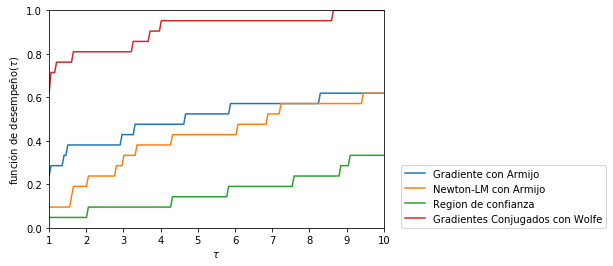

In [9]:
x = np.linspace(1,10,180)
vfuncion_desempeno_1 = np.vectorize(funcion_desempeno_1)
plt.axis([1, 10, 0, 1])
for j in range(0,len(algoritmos)):
    plt.plot(x, vfuncion_desempeno_1(x,j), label=algoritmos[j][0])
plt.legend(loc=(1.05,0))
plt.xlabel(r'$\tau$')
plt.ylabel(r'función de desempeño($\tau$)')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

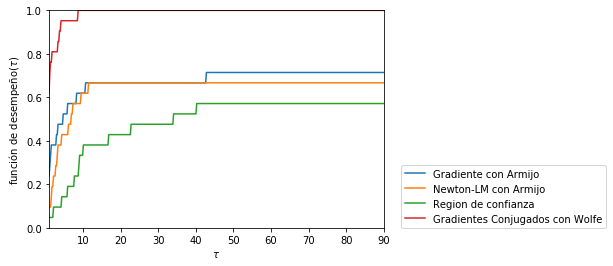

In [10]:
y = np.linspace(1,90,450)
vfuncion_desempeno_1 = np.vectorize(funcion_desempeno_1)
plt.axis([1, 90, 0, 1])
for j in range(0,len(algoritmos)):
    plt.plot(y, vfuncion_desempeno_1(y,j), label=algoritmos[j][0])
plt.legend(loc=(1.05,0))
plt.xlabel(r'$\tau$')
plt.ylabel(r'función de desempeño($\tau$)')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

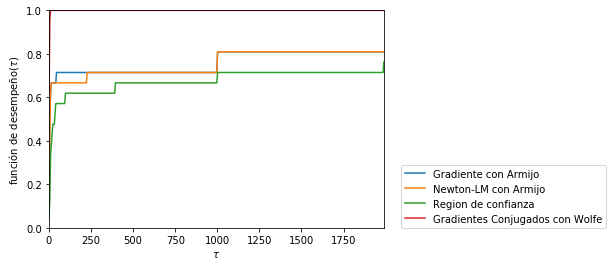

In [11]:
z = np.linspace(1,r_max_1,450)
vfuncion_desempeno_1 = np.vectorize(funcion_desempeno_1)
plt.axis([1, r_max_1, 0, 1])
for j in range(0,len(algoritmos)):
    plt.plot(z, vfuncion_desempeno_1(z,j), label=algoritmos[j][0])
plt.legend(loc=(1.05,0))
plt.xlabel(r'$\tau$')
plt.ylabel(r'función de desempeño($\tau$)')
plt.show

## Perfil 2

Nuevamente, dados el conjunto de problemas y de algoritmos a comparar (en este caso, el mismo algoritmo con distintos parámetros) calculamos la matriz C de costos (que ahora es la cantidad de iteraciones) y luego la matriz R con los índices de desempeño relativo. Definimos la función de desempeño que toma como parametros $ \tau $ y un algoritmo (su índice en el vector de parametros). Calculamos el $r_{max}$ y lo devolvemos junto con la función.

In [12]:
from f_tp_2 import puntos_iniciales, f0 as g0, f1 as g1, f2 as g2, f3 as g3, f4 as g4, f5 as g5, f6 as g6, f7 as g7, f8 as g8, f9 as g9, f10 as g10, f11 as g11, f12 as g12, f13 as g13, f14 as g14, f15 as g15, f16 as g16, f17 as g17, f18 as g18, f19 as g19

parametros = [
    ("Delta = 1, Eta = 0.2", 1, 0.2),
    ("Delta = 1.55, Eta = 0.3", 1.55, 0.3),
    ("Delta = 0.55, Eta = 0.15", 0.55, 0.15), 
    ("Delta = 2, Eta = 0.01", 2, 0.01)
]
problemas_2 = [g0, g1, g2, g3, g4, g5, g6, g7, g8, g9, g10, g11, g12, g13, g14, g15, g16, g17, g18, g19]

def perfil_2(parametros, problemas):
    n, m = len(problemas), len(parametros)
    C = np.zeros([n, m])
    R = np.zeros([n, m])

    for j in range(0,m):
        for i in range(0,n):
        
            it, x = met_reg_confianza_cauchy(problemas[i], puntos_iniciales[i], delta=parametros[j][1], eta=parametros[j][2], eps=1e-7, it_max=300)
            
            if it == 300:
                k = 1e8
            else:
                k = it 
           
            C[i,j] = k
      
    for j in range(0,m):
        for i in range(0,n):
            R[i,j] = C[i,j]/ (min(C[i,:]))
    
    def funcion_desempeno(tau, algoritmo):
        numerador = sum(1 for i in range(0,n) if R[i,algoritmo] <= tau)
        denominador = sum(1 for i in range(0,n))
        return numerador/denominador
       
    lista=[]
    for j in range(0,m):
        for i in range(0,n):
            if C[i,j] != 1e8:
                lista.append(R[i,j])
    r_max = max(lista)
    
    return funcion_desempeno, r_max

funcion_desempeno_2, r_max_2 = perfil_2(parametros,problemas_2)

Calculamos la eficiencia y la robustez de cada algoritmo evaluando la función de desempeño en 1 y en $r_{max}$ respectivamente para cada algoritmo.

In [13]:
datos_2b = []
index_2b = []

for j in range(0,len(parametros)):
    datos_2b.append([funcion_desempeno_2(1,j),funcion_desempeno_2(r_max_2,j)])
    index_2b.append(parametros[j][0])
    
df = pd.DataFrame(datos_2b, index=index_2b, columns=["Eficiencia", "Robustez"])
df

,Eficiencia,Robustez
"Delta = 1, Eta = 0.2",0.50,1.00
"Delta = 1.55, Eta = 0.3",0.25,0.70
"Delta = 0.55, Eta = 0.15",0.30,1.00
"Delta = 2, Eta = 0.01",0.50,0.95


Como podemos observar, los métodos de región de confianza con parámetros $ \delta $ = 1, $\eta$ = 0.2 y $\delta$ = 2, $\eta$ = 0.01 son los más eficientes, ambos con una eficiencia del 50%. A diferencia del perfil anterior, en este, si se suman las eficiencias de los cuatro algoritmos da mas de 1, con lo cual, para ciertos problemas hay varios algoritmos que lo resuelven con el costo mínimo. La diferencia es que ahora estamos tomando como costo la cantidad de iteraciones, entonces puede pasar que dos algoritmos hagan la misma cantidad de iteraciones, pero es muy poco probable que tarden exactamentamente el mismo tiempo, que es lo que se tomaba como costo en el perfil anterior. Además cada vez que se corre este perfil el resultado es el mismo mientras que en el otro puede variar un poco porque el tiempo de cómputo para cada algoritmo ni siquiera es igual de una corrida a otra. Los métodos con $\delta$ = 1.55, $\eta$ = 0.3 y $\delta$ = 0.55, $\eta$ = 0.15 son un poco menos eficientes, es decir, en varios casos, necesitan mas iteraciones para resolver los problemas que los métodos con $\delta$ = 1, $\eta$ = 0.2 y $\delta$ = 2, $\eta$ = 0.01. Sin embargo, el método con parámetros $\delta$ = 0.55, $\eta$ = 0.15 es uno de los mas robustos, que al igual que con $\delta$ = 1, $\eta$ = 0.2, logra resolver el 100% de los problemas. Pero el único que es tanto de los mas robustos como de los mas eficientes es el método de región de confianza con parametros $\delta$ = 1, $\eta$ = 0.2.

Para ver mejor como varía la función de desempeño en función de $\tau$ realizamos dos gráficos. El primero para valores chicos de $\tau$, donde se aprecia mejor la eficiencia y el segundo para valores un poco mas grandes, donde se aprecia mejor la robustez. Podemos ver que el método con $\delta$ = 1.55, $\eta$ = 0.3 está siempre por abajo del resto, con lo cual es el que peor desmpeño tuvo en este perfil. Y el método con $\delta$ = 1, $\eta$ = 0.2, si bien no esta por encima de los otros para todos los valores de tau, sí los esta para la mayoria de ellos además de que es de los mas eficientes y de los mas robustos, por lo que podriamos decir que es el que obtuvo mejor desempeño

<function matplotlib.pyplot.show(*args, **kw)>

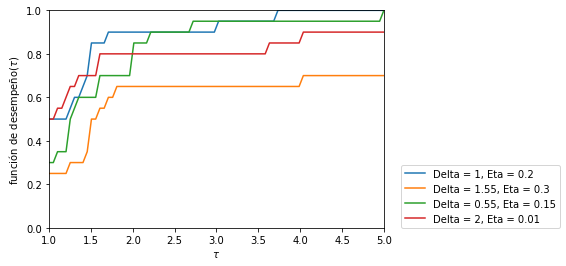

In [14]:
x = np.linspace(1,5,80)
vfuncion_desempeno_2 = np.vectorize(funcion_desempeno_2)
plt.axis([1, 5, 0, 1])
for j in range(0,len(parametros)):
    plt.plot(x, vfuncion_desempeno_2(x,j), label=parametros[j][0])
plt.legend(loc=(1.05,0))
plt.xlabel(r'$\tau$')
plt.ylabel(r'función de desempeño($\tau$)')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

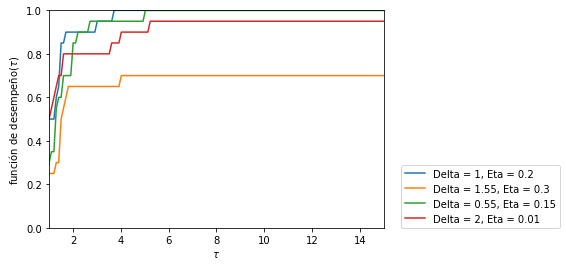

In [15]:
y = np.linspace(1,15,140)
vfuncion_desempeno_2 = np.vectorize(funcion_desempeno_2)
plt.axis([1, 15, 0, 1])
for j in range(0,len(parametros)):
    plt.plot(y, vfuncion_desempeno_2(y,j), label=parametros[j][0])
plt.legend(loc=(1.05,0))
plt.xlabel(r'$\tau$')
plt.ylabel(r'función de desempeño($\tau$)')
plt.show